## 1. install dependecies and setup

In [1]:
%pip install tensorflow opencv-python matplotlib

You should consider upgrading via the '/Users/ranak/Developer/dat255/imageclassification/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


!pip list

In [2]:
import tensorflow as tf
import os

2025-04-24 17:48:13.850065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import cv2
import imghdr

In [4]:
data_dir = 'data/EuroSAT_RGB' 
for image_class in os.listdir(data_dir):
  class_path = os.path.join(data_dir, image_class)
  if os.path.isdir(class_path):  # check if it's a directory
    print(f'Class: {image_class}')



Class: Forest
Class: River
Class: Highway
Class: AnnualCrop
Class: SeaLake
Class: HerbaceousVegetation
Class: Industrial
Class: Residential
Class: PermanentCrop
Class: Pasture


## 2. load data

In [68]:
#tf.data.Dataset??
import numpy as np
from matplotlib import pyplot as plt
#tf.keras.utils.image_dataset_from_directory??
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(64, 64))

Found 27000 files belonging to 10 classes.


In [69]:
data_iterator = data.as_numpy_iterator()

In [70]:
batch = data_iterator.next()
# images as numpy arrays
batch[0].shape
batch[0].max(), batch[0].min()

(255.0, 24.0)

In [54]:
batch[1]

array([0, 0, 6, 4, 3, 8, 3, 0, 0, 9, 9, 9, 1, 8, 3, 4, 7, 5, 3, 7, 1, 1,
       3, 1, 1, 7, 9, 1, 3, 3, 0, 6], dtype=int32)

In [71]:
#print(data.class_names)
class_mapping = {i: name for i, name in enumerate(data.class_names)}
print(class_mapping)

{0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}


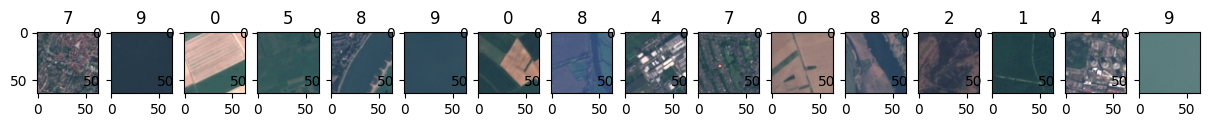

In [72]:
fig, ax = plt.subplots(ncols=16,figsize=(15, 15))
for idx, img in enumerate(batch[0][:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 3. prepeocess data

  3.1 scale data

In [73]:
data = data.map(lambda x, y: (x / 255.0, y))

In [74]:
scaled_iterator = data.as_numpy_iterator()
scaled_batch = scaled_iterator.next()
scaled_batch[0].max(), scaled_batch[0].min()

(1.0, 0.0627451)

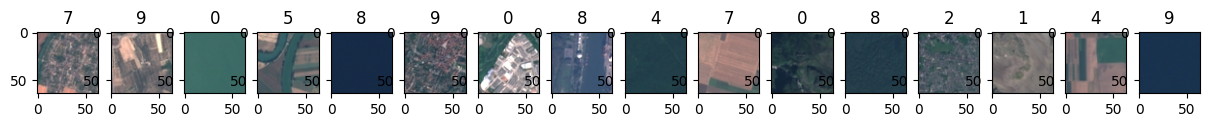

In [75]:
fig, ax = plt.subplots(ncols=16,figsize=(15, 15))
for idx, img in enumerate(scaled_batch[0][:16]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

  3.2 split data

In [76]:
len(data)  # number of batches


844

In [78]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)+1
test_size = int(len(data) * 0.15)+1
val_size+test_size+train_size

844

In [79]:
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)
print(f'Train size: {train_size}, Validation size: {val_size}, Test size: {test_size}')

Train size: 590, Validation size: 127, Test size: 127


## 4. Deep Model

  4.1 build deep learnin model

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [82]:
model = Sequential()
# add layers
model.add(Conv2D(32, (3, 3), 1, padding='same', activation='relu', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), 1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), 1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # to prevent overfitting
model.add(Dense(10, activation='softmax')) # 10 classes

/Users/ranak/Developer/dat255/imageclassification/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [83]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,194,122 (8.37 MB)

 Trainable params: 2,193,674 (8.37 MB)

 Non-trainable params: 448 (1.75 KB)

  4.2 train

In [85]:
logdir = 'logs'

In [86]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

In [87]:
hist = model.fit(train_data, epochs=10, validation_data=val_data, callbacks=[tensorboard_callback])

Epoch 1/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 133s 219ms/step - accuracy: 0.4433 - loss: 2.2081 - val_accuracy: 0.5600 - val_loss: 1.3335
Epoch 2/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 205ms/step - accuracy: 0.6068 - loss: 1.1287 - val_accuracy: 0.3152 - val_loss: 3.3982
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 117s 199ms/step - accuracy: 0.6688 - loss: 0.9373 - val_accuracy: 0.6873 - val_loss: 1.0574
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 206ms/step - accuracy: 0.7216 - loss: 0.8173 - val_accuracy: 0.6629 - val_loss: 1.0656
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 127s 215ms/step - accuracy: 0.7579 - loss: 0.7206 - val_accuracy: 0.6009 - val_loss: 1.3297
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 206ms/step - accuracy: 0.7788 - loss: 0.6518 - val_accuracy: 0.4599 - val_loss: 2.9179
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 119s 202ms/step - accuracy: 0.8164 - loss: 0.5671 - val_accuracy: 0.7360 - val_loss: 0.9335
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 125s 211ms/step - accuracy: 0.8271 -

  4.3 plot performance

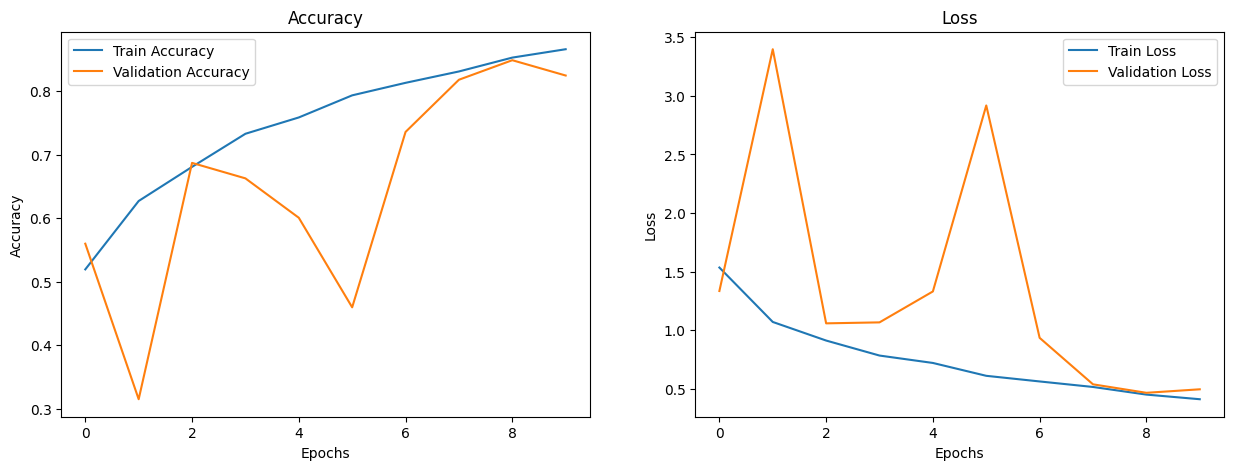

In [88]:
fig = plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label='Train Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 5. Evaluate performance

  5.1 Evaluate

In [92]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test accuracy: {test_accuracy:.4f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.7997 - loss: 0.5738
Test accuracy: 0.8030


  5.2 Test

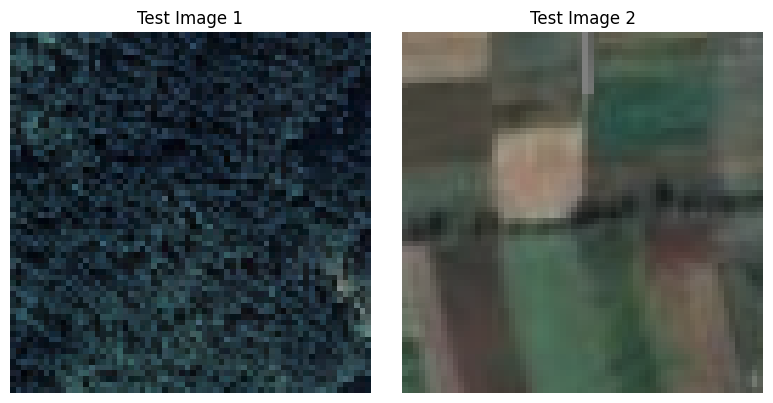

In [122]:
img1 = cv2.imread('test/1.png')
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
resized_img1 = tf.image.resize(img1_rgb, (64, 64))

img2 = cv2.imread('test/2.png')
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
resized_img2 = tf.image.resize(img2_rgb, (64, 64))

# Create a figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Display the first image
axes[0].imshow(resized_img1.numpy().astype(np.uint8))
axes[0].set_title('Test Image 1')
axes[0].axis('off')

# Display the second image
axes[1].imshow(resized_img2.numpy().astype(np.uint8))
axes[1].set_title('Test Image 2')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [123]:
np.expand_dims(resized_img1, 0).shape

(1, 64, 64, 3)

In [ ]:
yhat = model.predict(np.expand_dims(resized_img1/255, 0))
#yhat = model.predict(np.expand_dims(resized_img2/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [126]:
# Get the predicted class index
predicted_class_idx = np.argmax(yhat[0])

# Get the class name
predicted_class = class_mapping[predicted_class_idx]
confidence = yhat[0][predicted_class_idx] * 100

print(f"Predicted class: {predicted_class} with {confidence:.2f}% confidence")

# top 3 predictions
top3_indices = np.argsort(yhat[0])[-3:][::-1]
print("\nTop 3 predictions:")
for idx in top3_indices:
    print(f"{class_mapping[idx]}: {yhat[0][idx]*100:.2f}%")

Predicted class: Pasture with 41.44% confidence

Top 3 predictions:
Pasture: 41.44%
AnnualCrop: 34.14%
HerbaceousVegetation: 17.86%
